In [1]:
import pandas as pd; import numpy as np; import matplotlib as mtpl; import matplotlib.pyplot as plt;import time;import timeit
import random; from collections import Counter; import signalz

font = {'family' : 'serif','weight' : 'ultralight','size'   : 14};mtpl.rc('font', **font)

In [2]:
def Smooth121(x):
    signal = x
    length = len(signal)
    output = np.zeros(length-2)
    coef= np.array([1,2,1])
    for i in range(length - 2):
        output[i]= np.sum(signal[i:i+3] * coef / 4)
    return output

def Haar(t,x,plot=False,smooth=False):
    x=np.array(x);t=np.array(t)    
    #Cálculo deltas
    deltas_t=[];epsilons=[]
    for i in range(1,int(len(t)/2)+1):  #steps: i from 1 to n/2 
        deltas_t.append(t[i:]-t[:-i]) #0= Delta_t1, 1= Delta_t2, ..., [n/2]-1 = Delta_tn/2
    for i in range(1,len(deltas_t)+1): #for all my deltas_t (all steps-differences, de 1 en 1, de 2 en 2, etc)
        epsilons.append(deltas_t[i-1][:-i]/(deltas_t[i-1][:-i]+deltas_t[i-1][i:]))
    x=x[:-1];t=t[:-1]
    print('t samples:',len(t))
    print('deltas_t steps: from 1 to',len(deltas_t))
    print('epsilons steps:',len(epsilons))

    #Cálculo fluctuaciones
    Hs=[]; delta_t=[]; ep_min=0.25; ep_max=1-ep_min; calib=2; counter=0
    for H in range(2,len(x)-1,2):
        for start in range(len(x)-H-1):
            int1=np.sum(x[start:start+int(H/2)]*deltas_t[0][start:start+int(H/2)]/deltas_t[int(H/2)-1][start])
            int2=np.sum(x[start+int(H/2):start+H]*deltas_t[0][start+int(H/2):start+H]/deltas_t[int(H/2)-1][start+int(H/2)])
            counter+=1
            if ep_min<epsilons[int(H/2)-1][start] and epsilons[int(H/2)-1][start]<ep_max:
                #Hs.append(calib*abs(int2-int1)) #S_1
                Hs.append((calib*(int2-int1))**2) #S_2 (falta despues sacar raíz)
                delta_t.append(deltas_t[int(H/2)-1][start]+deltas_t[int(H/2)-1][start+int(H/2)]) #No logaritmicos           

    print(counter-len(Hs),' fluctuaciones eliminadas (',(counter-len(Hs))/counter*100,'%)')
    
    #Paso a dataframes
    data_df=pd.DataFrame(data={'delta t':delta_t , 'Hs': Hs}); data_sorted=data_df.sort_values('delta t',axis=0).reset_index(drop=True)

    #plt.subplots(figsize=(15, 7))
    #plt.title(' Scatter Haar fluctuation',fontsize=20);plt.xlabel('Log\u2081\u2080\u0394 t (Ky)',fontsize=18);plt.ylabel('Log\u2081\u2080 S\u2082(\u0394 t)^1/2',fontsize=18)
    #plt.plot(data_df['delta t'],np.sqrt(data_df['Hs']),'.');plt.show()

    max_t=max(np.log10(data_sorted['delta t'])); min_t=min(np.log10(data_sorted['delta t']))
    n_bins=int(((max_t)-(min_t))*20); rango_int=(max_t-min_t)/n_bins; time=np.array([]); ave_values=np.array([]); upper=np.array([]); lower=np.array([]);
    for i in range(n_bins):
        interval=data_sorted[(i*rango_int+min_t<=np.log10(data_sorted['delta t']))&(np.log10(data_sorted['delta t'])<min_t+(i+1)*rango_int)]
        time=np.append(time,((i*rango_int+min_t)+((i+1)*rango_int+min_t))/2)
        ave_values=np.append(ave_values,np.sqrt(interval.mean()[1]))        ## Tomo el sqrt del <[2*(x1-x2)]^2> ...
        upper=np.append(upper,np.sqrt(interval.mean()[1]+interval.std()[1]/np.sqrt(len(interval))))
        lower=np.append(lower,np.sqrt(interval.mean()[1]-interval.std()[1]/np.sqrt(len(interval))))
        
    if smooth==False:
        smooth_val=ave_values
    if smooth==True:
        smooth_val=Smooth121(ave_values)
        upper=Smooth121(upper)
        lower=Smooth121(lower)
        time=time[1:-1]
    val_mask = np.isfinite(smooth_val)
    
    time=time[val_mask] #??
    smooth_val=smooth_val[val_mask] #??
    
    if plot==True:
        plt.subplots(figsize=(15, 7))
        plt.title(' Sin test Haar fluctuation',fontsize=20);plt.xlabel('Log\u2081\u2080\u0394 t (Ky)',fontsize=18);plt.ylabel('Log\u2081\u2080 S\u2082(\u0394 t)^1/2',fontsize=18)
        for i in range(n_bins):
            plt.axvline(x = i*rango_int+min_t,linestyle='-.',linewidth=0.5)
        plt.plot(time,np.log10(smooth_val),'.-',color='black',linewidth=2,label='Log binning')
        plt.legend()
        plt.show()

    return data_sorted['delta t'],data_sorted['Hs'],time,smooth_val,upper,lower

In [16]:
#High frequencies: Periodo 5y Periodo 30y Periodo 100y 
#Low frequencies: Periodo 20ky Periodo 40ky Periodo 100ky 
def wave(res1,res2,res3,res4,res5,res6,name):    
    
    kyears1=2; 
    kyears2=10;
    kyears3=20;
    kyears4=50;
    kyears5=100;
    kyears6=200;    
    
    t11 = np.arange(0, kyears1, res1); t21 = np.arange(0, kyears1, res1); t31 = np.arange(0, kyears1, res1);
    x11 = 0.1*np.sin(2000*np.pi*t11/5); x21 = 0.2*np.sin(2000*np.pi*t21/30); x31 = 0.1*np.sin(2000*np.pi*t31/100);
    t41 = np.arange(0, kyears1, res1); t51 = np.arange(0, kyears1, res1); t61 = np.arange(0, kyears1, res1);
    x41 = 3*np.sin(2*np.pi*t41/20); x51 = 2*np.sin(2*np.pi*t51/40); x61 = 1.5*np.sin(2*np.pi*t61/100); 
    T1=x11+x21+x31+x41+x51+x61

    
    t12 = np.arange(kyears1, kyears2, res2); t22 = np.arange(kyears1, kyears2, res2); t32 = np.arange(kyears1, kyears2, res2);
    x12 = 0.1*np.sin(2000*np.pi*t12/5); x22 = 0.2*np.sin(2000*np.pi*t22/30); x32 = 0.1*np.sin(2000*np.pi*t32/100);
    t42 = np.arange(kyears1, kyears2, res2); t52 = np.arange(kyears1, kyears2, res2); t62 = np.arange(kyears1, kyears2, res2);
    x42 = 3*np.sin(2*np.pi*t42/20); x52 = 2*np.sin(2*np.pi*t52/40); x62 = 1.5*np.sin(2*np.pi*t62/100); 
    T2=x12+x22+x32+x42+x52+x62

    t13 = np.arange(kyears2, kyears3, res3); t23 = np.arange(kyears2, kyears3, res3); t33 = np.arange(kyears2, kyears3, res3);
    x13 = 0.1*np.sin(2000*np.pi*t13/5); x23 = 0.2*np.sin(2000*np.pi*t23/30); x33 = 0.1*np.sin(2000*np.pi*t33/100); 
    t43 = np.arange(kyears2, kyears3, res3); t53 = np.arange(kyears2, kyears3, res3); t63 = np.arange(kyears2, kyears3, res3);
    x43 = 3*np.sin(2*np.pi*t43/20); x53 = 2*np.sin(2*np.pi*t53/40); x63 = 1.5*np.sin(2*np.pi*t63/100); 
    T3=x13+x23+x33+x43+x53+x63

    t14 = np.arange(kyears3, kyears4, res4); t24 = np.arange(kyears3, kyears4, res4); t34 = np.arange(kyears3, kyears4, res4);
    x14 = 0.1*np.sin(2000*np.pi*t14/5); x24 = 0.2*np.sin(2000*np.pi*t24/30); x34 = 0.1*np.sin(2000*np.pi*t34/100);
    t44 = np.arange(kyears3, kyears4, res4); t54 = np.arange(kyears3, kyears4, res4); t64 = np.arange(kyears3, kyears4, res4);
    x44 = 3*np.sin(2*np.pi*t44/20); x54 = 2*np.sin(2*np.pi*t54/40); x64 = 1.5*np.sin(2*np.pi*t64/100); 
    T4=x14+x24+x34+x44+x54+x64

    t15 = np.arange(kyears4, kyears5, res5); t25 = np.arange(kyears4, kyears5, res5); t35 = np.arange(kyears4, kyears5, res5);
    x15 = 0.1*np.sin(2000*np.pi*t15/5); x25 = 0.2*np.sin(2000*np.pi*t25/30); x35 = 0.1*np.sin(2000*np.pi*t35/100); 
    t45 = np.arange(kyears4, kyears5, res5); t55 = np.arange(kyears4, kyears5, res5); t65 = np.arange(kyears4, kyears5, res5);
    x45 = 3*np.sin(2*np.pi*t45/20); x55 = 2*np.sin(2*np.pi*t55/40); x65 = 1.5*np.sin(2*np.pi*t65/100); 
    T5=x15+x25+x35+x45+x55+x65

    t16 = np.arange(kyears5, kyears6, res6); t26 = np.arange(kyears5, kyears6, res6); t36 = np.arange(kyears5, kyears6, res6);
    x16 = 0.2*np.sin(2000*np.pi*t16/5); x26 = 0.2*np.sin(2000*np.pi*t26/30); x36 = 0.2*np.sin(2000*np.pi*t36/100);
    t46 = np.arange(kyears5, kyears6, res6); t56 = np.arange(kyears5, kyears6, res6); t66 = np.arange(kyears5, kyears6, res6);
    x46 = 3*np.sin(2*np.pi*t46/20); x56 = 2*np.sin(2*np.pi*t56/40); x66 = 1.5*np.sin(2*np.pi*t66/100); 
    T6=x16+x26+x36+x46+x56+x66

    T=np.concatenate((T1, T2, T3, T4, T5, T6)); t=np.concatenate((t11, t12, t13, t14, t15, t16))
    print('Len T1: ',len(T1),' Len T2: ',len(T2),' Len T3: ',len(T3),' Len T4: ',len(T4),' Len T5: ',len(T5),' Len T6: ',len(T6))
    print('Len total: ',len(T))
    
    colors = ['#2D7FB8','#FF7F17','#2CA02C','#D62728','#9468BD','#A67D75']
    col_dic = {'0.005':'#2D7FB8','0.01':'#FF7F17','0.015':'#2CA02C','0.035':'#2CA02C','0.05':'#D62728','0.1':'#9468BD','0.2':'#A67D75'}

    plt.subplots(figsize=(17, 8))
    plt.plot(t11,T1,'-',color=col_dic[str(res1)])#,label=str(res1)+'ky resolution')
    plt.plot(t12,T2,'-',color=col_dic[str(res2)])#,label=str(res2)+'ky resolution')
    plt.plot(t13,T3,'-',color=col_dic[str(res3)],label=str(res3)+'ky resolution')
    plt.plot(t14,T4,'-',color=col_dic[str(res4)],label=str(res4)+'ky resolution')
    plt.plot(t15,T5,'-',color=col_dic[str(res5)],label=str(res5)+'ky resolution')
    plt.plot(t16,T6,'-',color=col_dic[str(res6)],label=str(res6)+'ky resolution')

    plt.title('Resolution '+str(name));plt.xlabel('t (Ky)');plt.ylabel('T (°C)')
    plt.grid(True, which='both');plt.axhline(y=0, color='k')
    plt.legend()
    #plt.savefig('1-Resolution test '+str(name)+'.jpg',bbox_inches='tight')
    plt.show()
    
    plt.subplots(figsize=(10, 8))
    plt.plot(t,'--')
    plt.title('Time steps '+str(name));plt.ylabel('t (Ky)');plt.xlabel('Samples')
    #plt.savefig('1-Time steps '+str(name)+'.jpg',bbox_inches='tight')
    plt.show()
    
    return t,T

In [3]:
dust_file='Dust records corregidos Completo.xlsx'
#dust_file='Dust records corregidos Completo Uniformes.xlsx'
#dust_file='EDC_DustFlux_25yr.xlsx'
id_columns=['Name','Data id','Latitud','Longitud','Age units','Data units','Data length']
id_data=pd.read_excel(dust_file,sheet_name=0,usecols=id_columns)
df_data=pd.read_excel(dust_file,sheet_name=1,skiprows=1)#skip row 1 o 0

#SEPARAR COLUMNAS
columns=df_data.size/len(df_data) ;lis=[];new_length=np.array([])

for i in range(int(columns)):
    if (i+1)%2==1: 
        dupla=df_data[[df_data.columns[i],df_data.columns[i+1]]].dropna() 
        dupla.index=[j for j in range(0, len(dupla))] 
        lis.append(dupla)
        new_length=np.append(new_length,np.shape(dupla)[0])
id_data

,Name,Data id,Latitud,Longitud,Age units,Data units,Data length
0,Vostok,1,-78.464167,106.865833,ka,(ug/m2/a),507
1,EPICA Dome C,2,-75.100000,123.350000,ka,(mg/m**2/a),298205
2,EPICA EDML,3,-75.002500,0.068400,ka,(ug/m**2/a),2303
3,Talos Dome,4,-72.817000,159.183000,ka BP,(µg/kg),64998
4,PS75/59-2,5,-54.215000,-125.425500,(kyr),(wt-%),2384
5,ML1208-17PC,6,0.480000,-156.450000,ka,(g/m2/yr),192
6,ML1208-31BB,7,4.680000,-160.050000,ka,(g/m2/yr),254
7,ML1208-37BB,8,7.040000,-161.630000,ka,(g/m2/yr),105
8,Xifeng,9,35.700000,107.600000,ka,(g/m^2/ka),722
9,Chinese Loess Plateau,10,35.760000,107.817333,ka,(g/cm3/ka),1801


Len T1:  134  Len T2:  534  Len T3:  667  Len T4:  600  Len T5:  500  Len T6:  500
Len total:  2935


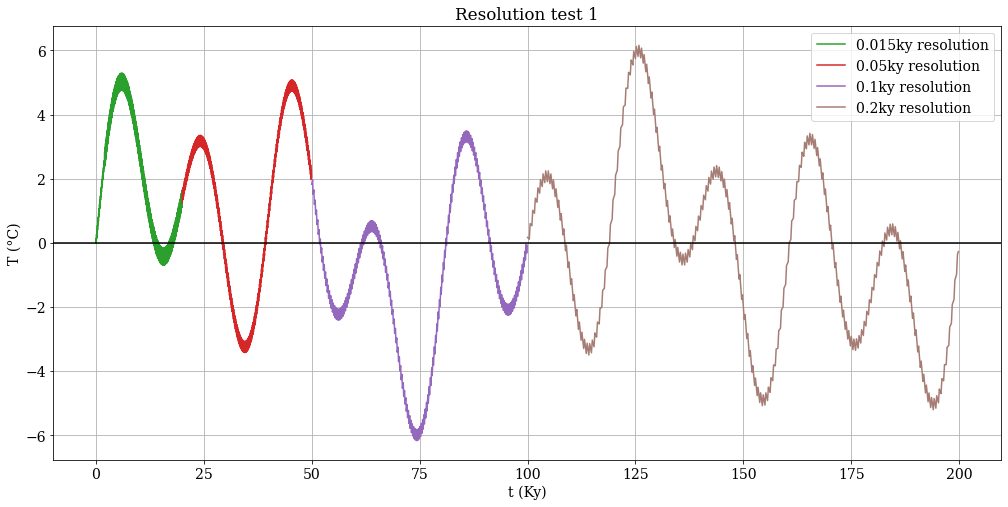

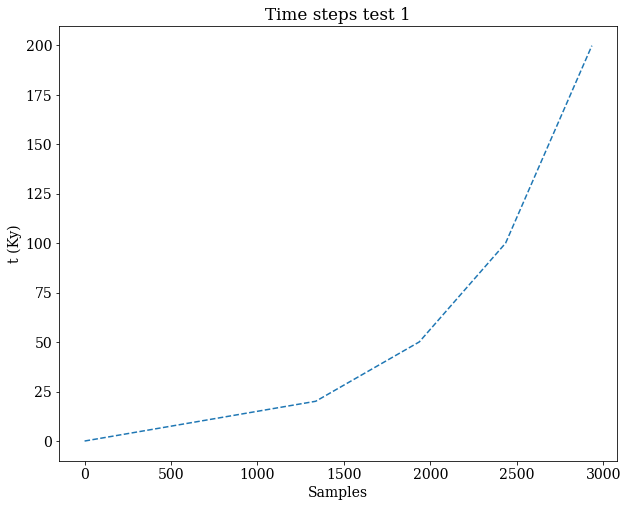

In [237]:
[t,T]=wave(0.015,0.015,0.015,0.05,0.1,0.2,'test 1')

In [327]:
t=t[:1000];T=T[:1000]

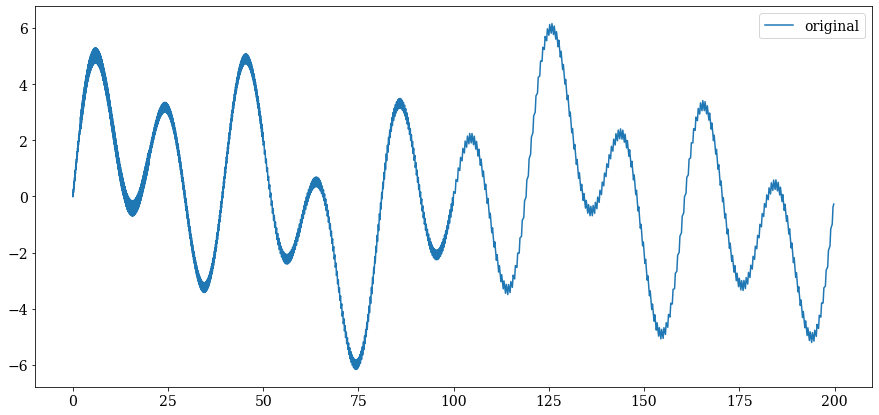

In [9]:
plt.subplots(figsize=(15, 7))
plt.plot(t,T,'-',label='original')
plt.legend()
plt.show()

In [434]:
ix=5
t=lis[ix][lis[ix].columns[0]]
T=lis[ix][lis[ix].columns[1]]

In [4]:
ix=12
t=lis[ix][lis[ix].columns[0]]
T=lis[ix][lis[ix].columns[1]]
[delta_t,hs,time,amp,app,low]=Haar(t,T,smooth=True)

t samples: 2727
deltas_t steps: from 1 to 1364
epsilons steps: 1364
55  fluctuaciones eliminadas ( 0.002962713975283424 %)


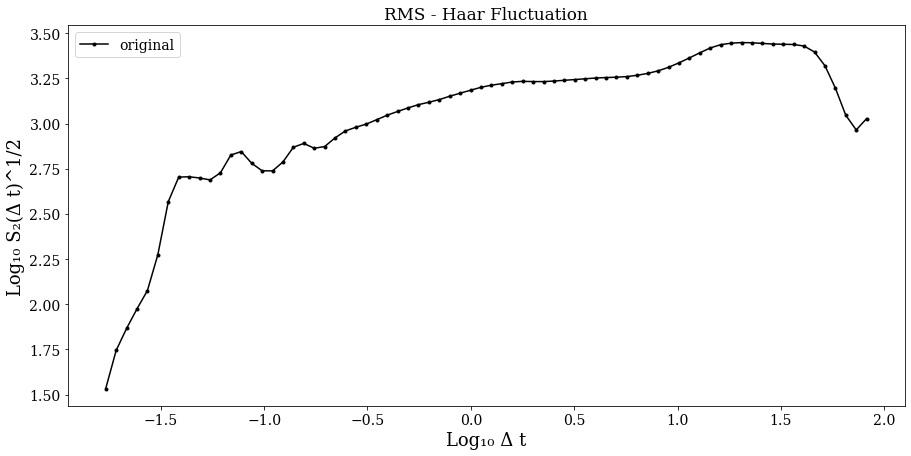

In [5]:
plt.subplots(figsize=(15, 7))
plt.plot(time,np.log10(amp),'.-',color='black',label='original')

plt.title('RMS - Haar Fluctuation')
plt.xlabel('Log\u2081\u2080 \u0394 t',fontsize=18);plt.ylabel('Log\u2081\u2080 S\u2082(\u0394 t)^1/2',fontsize=18)
plt.legend()
plt.show()

In [6]:
from scipy.stats import linregress
from scipy.signal import savgol_filter

In [258]:
#mientras mayor la ventana, menor la magnitud de la curva suavizada
#Mientras mayor el polyorder, más spiky's son capturadas obvio
#deriv, numero de redivadas

window

7

In [298]:
int(len(x)*0.3)

3

13
13
[ 1.00000000e+00  1.00000000e+00  1.00000000e+00  1.00000000e+00
  7.85714286e-01  4.28571429e-01  1.69759961e-17 -4.28571429e-01
 -7.85714286e-01 -1.00000000e+00 -1.00000000e+00 -1.00000000e+00
 -1.00000000e+00]


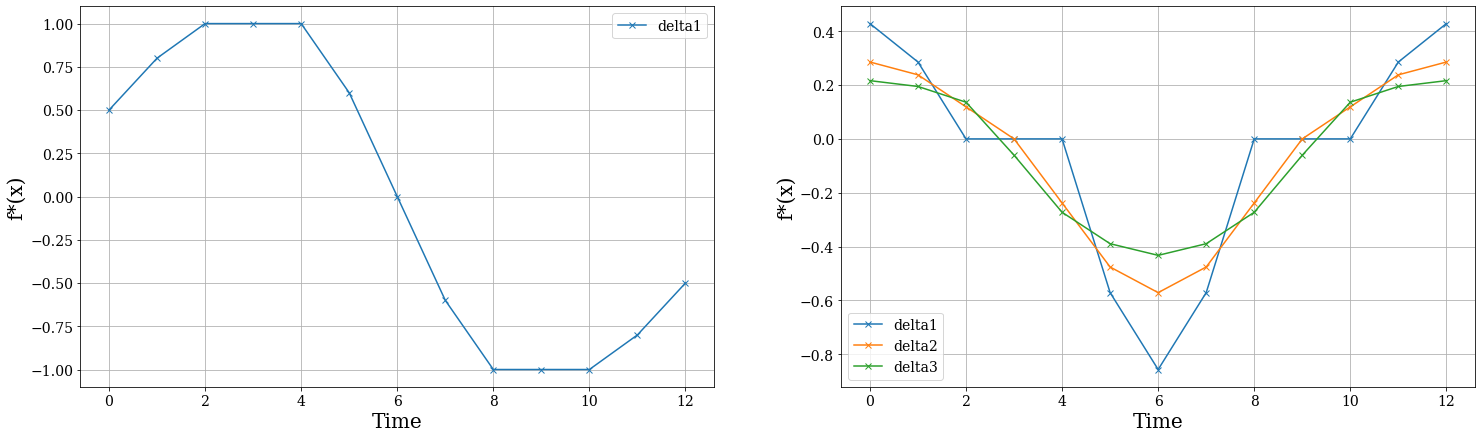

In [299]:
x=[0,1,2,3,4,5,6,7,8,9,10,11,12]
y=[0,1,2,3,4,5,6,5,4,3,2,1,0]

print(len(x))
print(len(savgol_filter(x, window_length=window, polyorder=2, deriv=1)))
print(savgol_filter(y, window_length=window, polyorder=2, deriv=1))

fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(25, 7))
#ax1.plot(x,y,'.-',label='Fx');
#ax1.set_xlabel('Time', fontsize = 20.0)
#ax1.set_ylabel('f(x)', fontsize = 20)
#ax1.set(xlim=[0,0.1],ylim=[-0.2,0.2])
#ax1.legend()
#ax1.grid()

#me quedaré con el modo nearest, delta= 1 default, 
ax1.plot(x,savgol_filter(y, window_length=5, polyorder=2, deriv=1,mode='nearest'),'x-',label='delta1');
#ax1.plot(x,savgol_filter(y, window_length=3, polyorder=2, deriv=1,mode='nearest'),'x-',label='delta2')
#ax1.plot(x,savgol_filter(y, window_length=3, polyorder=2, deriv=1,mode='nearest'),'x-',label='delta3')
ax1.set_xlabel('Time', fontsize = 20.0)
ax1.set_ylabel('f*(x)', fontsize = 20)
#ax2.set(xlim=[0,0.095],ylim=[-0.4,0.4])
#ax2.axvline(x=0.095/2)
ax1.grid()
ax1.legend()

ax2.plot(savgol_filter(y, window_length=5, polyorder=2, deriv=2,delta=1,mode='nearest'),'x-',label='delta1');
ax2.plot(savgol_filter(y, window_length=7, polyorder=2, deriv=2,delta=1,mode='nearest'),'x-',label='delta2')
ax2.plot(savgol_filter(y, window_length=9, polyorder=2, deriv=2,delta=1,mode='nearest'),'x-',label='delta3')
ax2.set_xlabel('Time', fontsize = 20.0)
ax2.set_ylabel('f*(x)', fontsize = 20)
ax2.grid()
ax2.legend()


plt.show()

impar
7


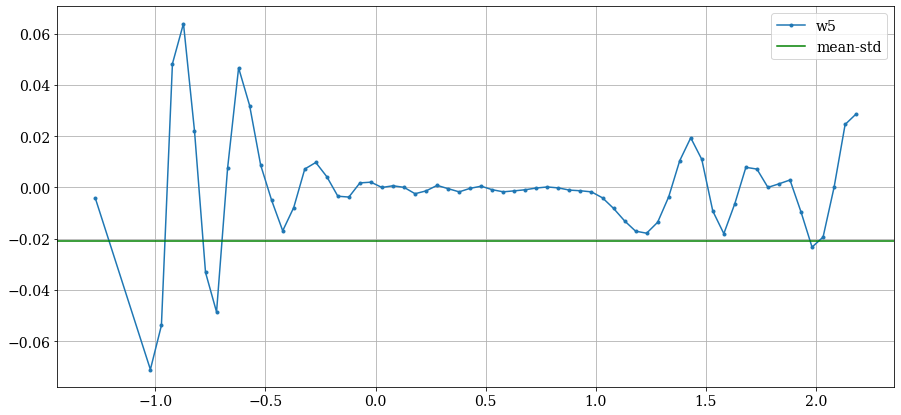

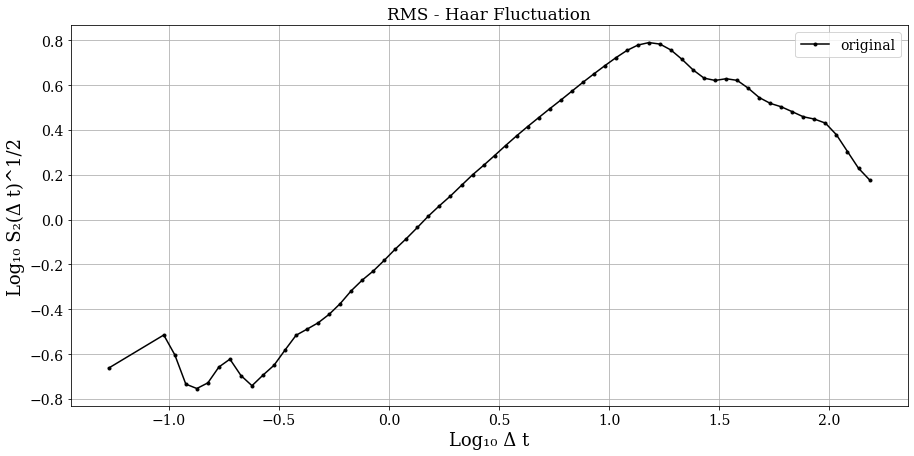

In [311]:
if np.round(len(time)*0.1)%2==1:
    print('impar')
    w=int(np.round(len(time)*0.1))
if np.round(len(time)*0.1)%2==0:
    print('par')
    w=int(np.round(len(time)*0.1)+1)
print(w)  
window = 7
der2=savgol_filter(np.log10(amp), window_length=5, polyorder=2, deriv=2,delta=1,mode='nearest')
plt.subplots(figsize=(15, 7))
plt.plot(time,savgol_filter(np.log10(amp), window_length=5, polyorder=2, deriv=2,delta=1,mode='nearest'),'.-',label='w5')
plt.grid()
#plt.axhline(y=min_der2/2,color='r',label='min/2')
plt.axhline(y=np.mean(der2)-np.std(der2),color='g',label='mean-std')
plt.legend()
plt.show();
plt.subplots(figsize=(15, 7))
plt.plot(time,np.log10(amp),'.-',color='black',label='original')
plt.grid()
plt.title('RMS - Haar Fluctuation')
plt.xlabel('Log\u2081\u2080 \u0394 t',fontsize=18);plt.ylabel('Log\u2081\u2080 S\u2082(\u0394 t)^1/2',fontsize=18)
plt.legend()
plt.show()

t samples: 2727
deltas_t steps: from 1 to 1364
epsilons steps: 1364
55  fluctuaciones eliminadas ( 0.002962713975283424 %)


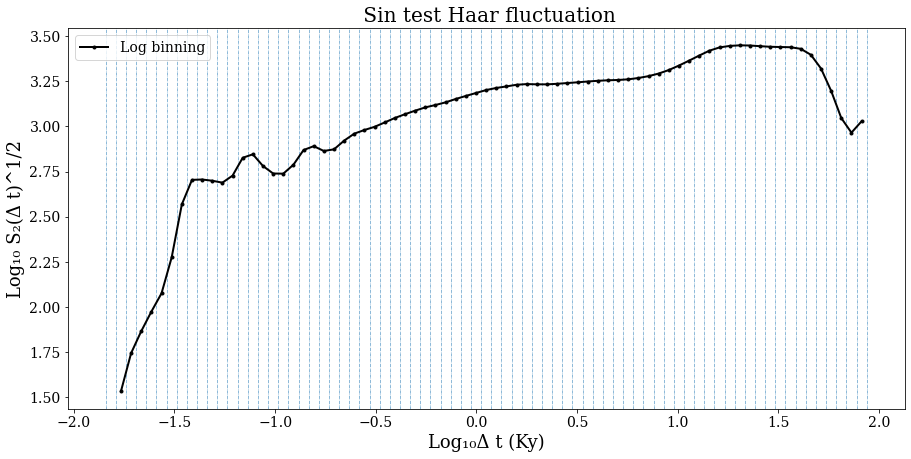

In [500]:
ix=12
t=lis[ix][lis[ix].columns[0]]
T=lis[ix][lis[ix].columns[1]]
[delta_t,hs,time,amp,app,low]=Haar(t,T,plot=True,smooth=True)

candidates  [ 0  4  5  9 10 15 16 71 72]



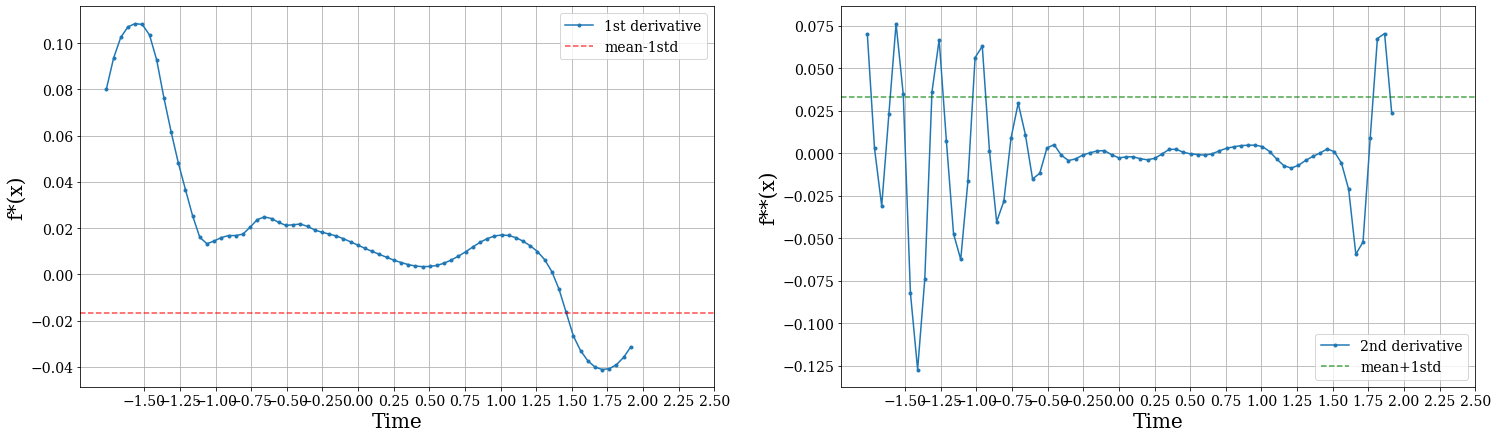

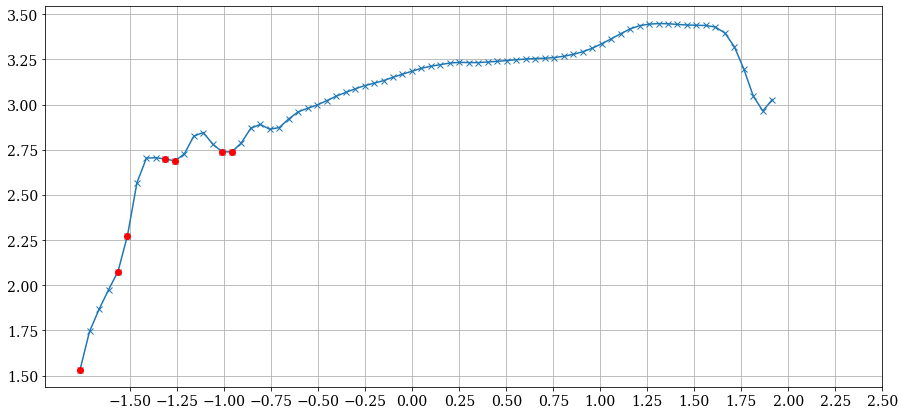

In [501]:
#ACA TRATO DE MODIFICAR EL THRESHOLD
 
window = 15

der1=savgol_filter(np.log10(amp), window_length=window, polyorder=2, deriv=1,delta=1,mode='nearest')
der2=savgol_filter(np.log10(amp), window_length=window, polyorder=9, deriv=2,delta=1,mode='nearest')

threshold1 = np.mean(der1)-np.std(der1)
threshold2 = np.mean(der2)+np.std(der2)

fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(25, 7))
ax1.plot(time,(der1),'.-',label='1st derivative')
ax1.axhline(y=threshold1,linestyle='--',color='r',label='mean-1std',alpha=0.7)
ax1.set_xlabel('Time', fontsize = 20.0)
ax1.set_ylabel('f*(x)', fontsize = 20)
#ax1.set(xlim=[0,0.1],ylim=[-0.2,0.2])
ax1.set_xticks([-1.5,-1.25,-1,-0.75,-0.5,-0.25,0,0.25,0.5,0.75,1,1.25,1.5,1.75,2,2.25,2.5])
ax1.legend()
ax1.grid()

ax2.plot(time,(der2),'.-',label='2nd derivative')
ax2.axhline(y=threshold2,linestyle='--',color='g',label='mean+1std',alpha=0.7)
ax2.set_xlabel('Time', fontsize = 20.0)
ax2.set_ylabel('f**(x)', fontsize = 20)
#ax2.set(xlim=[0,0.095],ylim=[-0.4,0.4])
#ax2.axvline(x=0.095/2)
ax2.set_xticks([-1.5,-1.25,-1,-0.75,-0.5,-0.25,0,0.25,0.5,0.75,1,1.25,1.5,1.75,2,2.25,2.5])
ax2.grid()
ax2.legend()



candidates = np.where(der2 > threshold2)[0]
print('candidates ',candidates)#,'\n',np.diff(candidates))
#gaps = np.diff(candidates) < 2*window
#print(gaps)
#print('candidates gap',candidates[1:][gaps])
#print(gaps)
#begins = np.insert(candidates[1:][gaps], 0, candidates[0])
#ends = np.append(candidates[:-1][gaps], candidates[-1])
#print('begins:',begins)
#print('ends:',ends)


changes = ((begins+ends)/2).astype(int)
begings=np.array(begins)
ends=np.array(ends)

print()
plt.subplots(figsize=(15, 7))
plt.plot(time,np.log10(amp),'x-')
plt.plot(time[candidates][time[candidates]<1], np.log10(amp)[candidates][time[candidates]<1], 'ro')
#plt.plot(time[ends], np.log10(amp)[ends], 'go')
plt.xticks([-1.5,-1.25,-1,-0.75,-0.5,-0.25,0,0.25,0.5,0.75,1,1.25,1.5,1.75,2,2.25,2.5])
plt.grid()
plt.show()


In [484]:
print(candidates)
print(time[candidates][time[candidates]<1])

[ 1  2  6 10 44 45 46]
[-0.51134205 -0.46108548 -0.26005922 -0.05903295]


In [448]:
begins2 = np.insert(candidates[1:][gaps], 0, candidates[0])
ends2 = np.append(candidates[:-1][gaps], candidates[-1])
print(begins2)
print(ends2)

[ 2  3  4 44 45 46 47]
[ 2  3 43 44 45 46 47]


In [450]:
time[ends]

array([ 2,  3, 23, 44, 45, 46, 47])

In [349]:
 np.where(der2[]<threshold2)

IndexError: arrays used as indices must be of integer (or boolean) type

In [345]:
np.where((der2 < threshold2) | (der1 < threshold1))[0]

array([ 1,  2,  3,  7,  8, 47, 48, 49, 54, 55, 61, 62, 63, 64],
      dtype=int64)

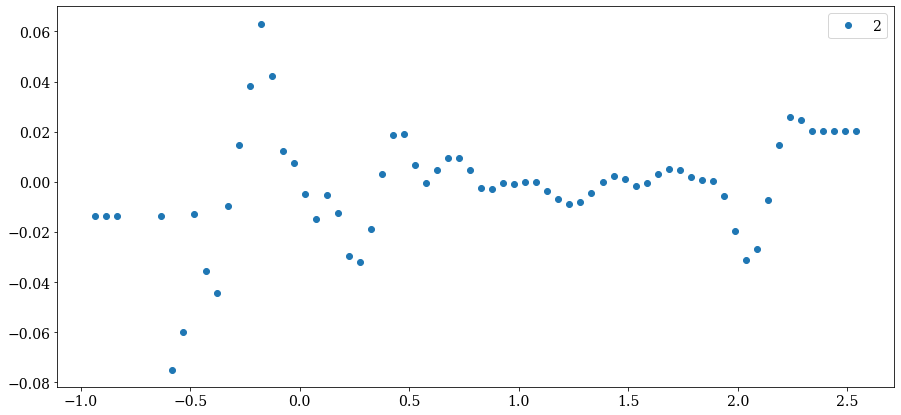

impar
7


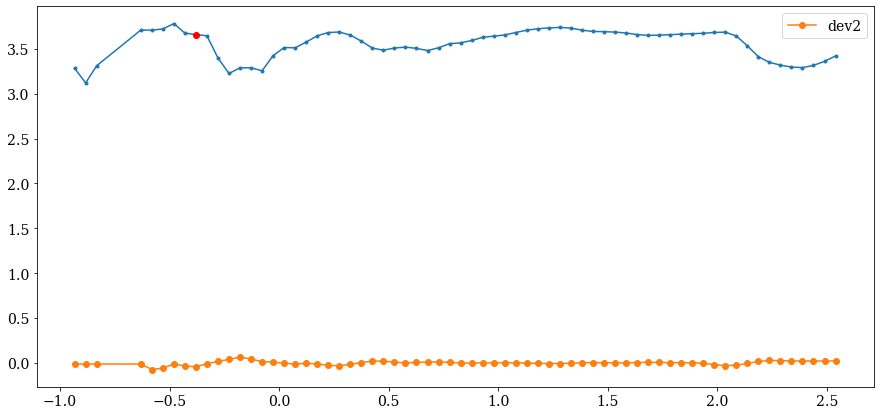

In [194]:
plt.subplots(figsize=(15, 7))
plt.plot(time,(der2),'o',label='2')
plt.legend()
plt.show()

if np.round(len(time)*0.1)%2==1:
    print('impar')
    w=int(np.round(len(time)*0.1))
if np.round(len(time)*0.1)%2==0:
    print('par')
    w=int(np.round(len(time)*0.1)+1)
print(w)  
window = 5
der2=savgol_filter(np.log10(amp), window_length=window, polyorder=2, deriv=2)
max_der2 = np.max(np.abs(der2))
large = np.where(np.abs(der2) > max_der2/2)[0]
gaps = np.diff(large) > window
begins = np.insert(large[1:][gaps], 0, large[0])
ends = np.append(large[:-1][gaps], large[-1])
changes = ((begins+ends)/2).astype(int)
plt.subplots(figsize=(15, 7))
plt.plot(time,np.log10(amp),'.-')
plt.plot(time,(der2),'o-',label='dev2')
plt.plot(time[changes], np.log10(amp)[changes], 'ro')
plt.legend()
plt.show()

In [218]:
int(np.mean(der2))
np.where(der2 < min_der2/2)

(array([4, 5, 8], dtype=int64),)

In [205]:
print(np.min(der2)) #max_der2   #será tau_c siempre el cambio más notorio? ojoo
print(np.where(der2 < min_der2/2)[0]) #large Si cambio el de arriba, creo que también debería cambiar este threshold
print(np.diff(large) > window) #gaps 
print(np.insert(large[1:][gaps], 0, large[0])) #begins
print(np.append(large[:-1][gaps], large[-1]))#end
print(((begins+ends)/2).astype(int)) #change

-0.07484005733246363
[4 5 8]
[False False]
4
[8]
[6]


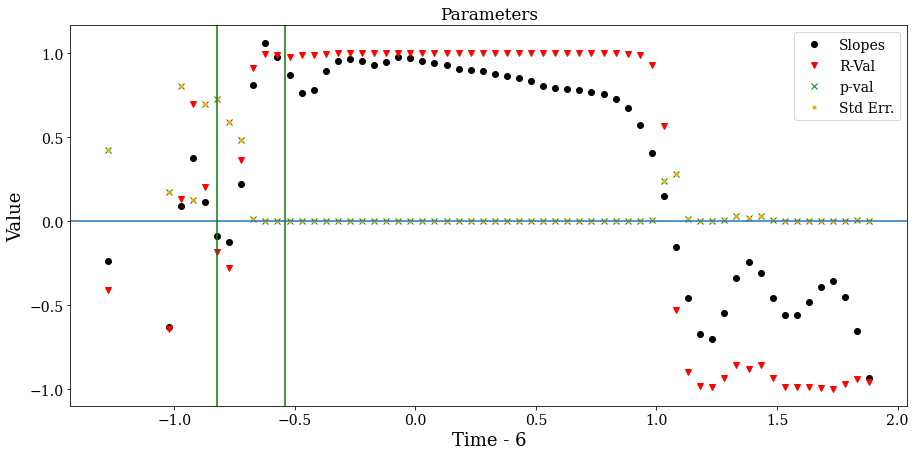

In [76]:
plt.subplots(figsize=(15, 7))
plt.title('Parameters')
plt.plot(time[:-points],slopes,'o',color='black',label='Slopes')
plt.plot(time[:-points],rval,'v',color='red',label='R-Val')
plt.plot(time[:-points],pval,'x',color='g',label='p-val')
plt.plot(time[:-points],stderror,'.',color='orange',label='Std Err.')
plt.xlabel('Time - 6',fontsize=18);plt.ylabel('Value',fontsize=18)
plt.axhline(y=0)
#plt.axvline(x=0)
#plt.axvline(x=0)
plt.axvline(np.mean(possible_tc)-np.std(possible_tc),color='g',linestyle='-') 
plt.axvline(np.mean(possible_tc)+np.std(possible_tc),color='g',linestyle='-')

plt.legend()
plt.show()

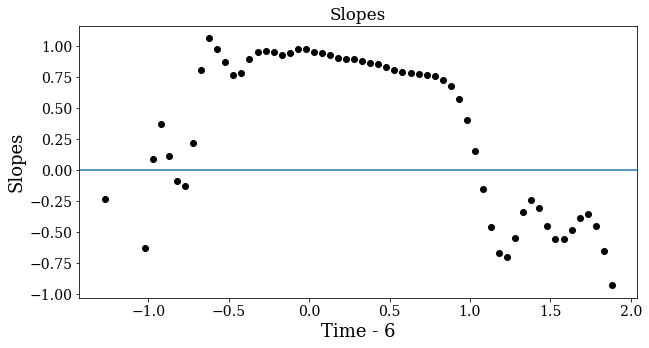

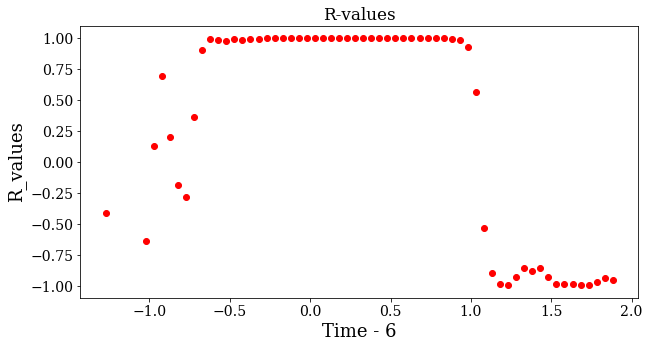

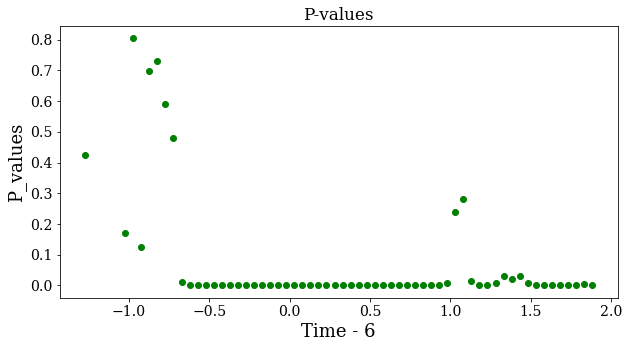

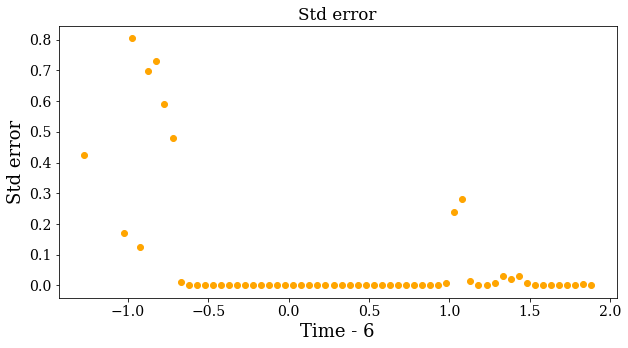

In [74]:
points=int(len(time)*0.1) #10% de los binnings ... redondeado hacia abajo... por que no hacia arriba?
slopes=np.array([])
interceptions=np.array([])
rval=np.array([])
pval=np.array([])
stderror=np.array([])
for i in range(len(time)-points): #Porque hasta -1? lo saqué
    #print(i,'- rvalue:',linregress(time[i:i+points], np.log10(amp[i:i+points])),'\n')
    slopes=np.append(slopes,linregress(time[i:i+points], np.log10(amp[i:i+points]))[0])
    interceptions=np.append(interceptions,linregress(time[i:i+points], np.log10(amp[i:i+points]))[1])
    rval=np.append(rval,linregress(time[i:i+points], np.log10(amp[i:i+points]))[2])
    pval=np.append(pval,linregress(time[i:i+points], np.log10(amp[i:i+points]))[3])
    stderror=np.append(stderror,linregress(time[i:i+points], np.log10(amp[i:i+points]))[3])

plt.subplots(figsize=(10, 5))
plt.title('Slopes')
plt.plot(time[:-points],slopes,'o',color='black')
plt.xlabel('Time - 6',fontsize=18);plt.ylabel('Slopes',fontsize=18)
plt.axhline(y=0)
plt.show()

plt.subplots(figsize=(10, 5))
plt.title('R-values')
plt.plot(time[:-points],rval,'o',color='red')
plt.xlabel('Time - 6',fontsize=18);plt.ylabel('R_values',fontsize=18)
#plt.axhline(y=0)
plt.show()

plt.subplots(figsize=(10, 5))
plt.title('P-values')
plt.plot(time[:-points],pval,'o',color='g')
plt.xlabel('Time - 6',fontsize=18);plt.ylabel('P_values',fontsize=18)
#plt.axhline(y=0)
plt.show()

plt.subplots(figsize=(10, 5))
plt.title('Std error')
plt.plot(time[:-points],stderror,'o',color='orange')
plt.xlabel('Time - 6',fontsize=18);plt.ylabel('Std error',fontsize=18)
#plt.axhline(y=0)
plt.show()

60

In [52]:
points=int(len(time)*0.1) #10% de los binnings ... redondeado hacia abajo... por que no hacia arriba?

#plt.subplots(figsize=(15, 7))
#plt.plot(time,np.log10(amp),'.-',color='black')

slopes=np.array([])
interceptions=np.array([])
rval=np.array([])
pval=np.array([])
stderror=np.array([])
for i in range(len(time)-points): #Porque hasta -1? lo saqué
    print(i,'- rvalue:',linregress(time[i:i+points], np.log10(amp[i:i+points])),'\n')
    slopes=np.append(slopes,linregress(time[i:i+points], np.log10(amp[i:i+points]))[0])
    interceptions=np.append(interceptions,linregress(time[i:i+points], np.log10(amp[i:i+points]))[1])
    rval=np.append(rval,linregress(time[i:i+points], np.log10(amp[i:i+points]))[2])
    pval=np.append(pval,linregress(time[i:i+points], np.log10(amp[i:i+points]))[3])
    stderror=np.append(stderror,linregress(time[i:i+points], np.log10(amp[i:i+points]))[3])
    #plt.plot(time[i:i+points],time[i:i+points]*slopes[i]+interceptions[i],'-')
    #print('slope ',i+1,': ',time[i:i+points],' ->',slopes[-1])
slope_dif=slopes[:-1]-slopes[1:]
print('Tengo en total ',len(time),' puntos')
print('Estoy tomando ',points,' puntos para sacar la pendiente:')
print('Len slopes',len(slopes),'   + ',points,'=',len(slopes)+points)
print('Len slopes_dif',len(slope_dif),'  es ',len(slopes),'-1\n')
possible_tc=np.array([])
for i in range(len(time[1:-points])):# de nuevo, por que -1?
    if slope_dif[i]<np.mean(slope_dif)-np.std(slope_dif) and time[i]<1: #esto esta muy manual... la segunda restriccion
        #plt.axvline(time[i+int(points/2)],color='r',label='cambio fuerte') 
        #plt.plot(time[i:i+points],time[i:i+points]*slopes[i]+interceptions[i],'-')
        possible_tc=np.append(possible_tc,time[i+int(points/2)])
        #plt.axvline(possible_tc[-1],color='r',linestyle='--',alpha=0.5) 
        
        print('Posible tau_c: ',10**possible_tc[-1]*1000,' y   dif n°',i)

print('\nPromedio tc: ',np.mean(possible_tc))
print('Std tc: ',np.std(possible_tc))
print('\nRango tc: [',10**(np.mean(possible_tc)-np.std(possible_tc))*1000,',',10**(np.mean(possible_tc)+np.std(possible_tc))*1000,']')


0 - rvalue: LinregressResult(slope=-0.23624946944084907, intercept=-0.8976188925145544, rvalue=-0.40717005968277864, pvalue=0.4229967549587206, stderr=0.2649740648810179, intercept_stderr=0.2627862892316432) 

1 - rvalue: LinregressResult(slope=-0.6323980427747847, intercept=-1.2326043387298529, rvalue=-0.6390911884196974, pvalue=0.1718776360611536, stderr=0.3805379658415271, intercept_stderr=0.34307249936309403) 

2 - rvalue: LinregressResult(slope=0.0893471734952686, intercept=-0.6072822527594187, rvalue=0.13147213014509154, pvalue=0.8039280474743138, stderr=0.33684564196726285, intercept_stderr=0.28688877149716485) 

3 - rvalue: LinregressResult(slope=0.3732590584696948, intercept=-0.4008190109335089, rvalue=0.696695766922152, pvalue=0.12403918412086201, stderr=0.19216682411347868, intercept_stderr=0.1540924224572369) 

4 - rvalue: LinregressResult(slope=0.11138398331055692, intercept=-0.6163804413229408, rvalue=0.20353195948801897, pvalue=0.6989177427887345, stderr=0.26790025450720

55 - rvalue: LinregressResult(slope=-0.38854614922689407, intercept=1.194641307885935, rvalue=-0.9949833777843089, pvalue=3.7686622274828154e-05, stderr=0.01953314290031926, intercept_stderr=0.0353468203940618) 

56 - rvalue: LinregressResult(slope=-0.35746724054602386, intercept=1.1373848167390632, rvalue=-0.9955205750984785, pvalue=3.0052930788019074e-05, stderr=0.01697443184413932, intercept_stderr=0.031566002879449356) 

57 - rvalue: LinregressResult(slope=-0.4482564501949853, intercept=1.3051447302113366, rvalue=-0.969959931811303, pvalue=0.0013400543808397528, stderr=0.056211077605745285, intercept_stderr=0.10734417026244113) 

58 - rvalue: LinregressResult(slope=-0.6535613023733052, intercept=1.69631537641407, rvalue=-0.9374754157617857, pvalue=0.005741771033803044, stderr=0.1213221094170091, intercept_stderr=0.23775572140152876) 

59 - rvalue: LinregressResult(slope=-0.9315968551165712, intercept=2.245344149515663, rvalue=-0.9547436585501627, pvalue=0.0030258590810719106, stder

Posible tau_c:  24.279509960575616  y   dif n° 0
Posible tau_c:  97.7791783413348  y   dif n° 12
Posible tau_c:  109.81548627453031  y   dif n° 13

Promedio tc:  -1.1946167034969022

Std tc:  0.29779838610237125

Rango tc: [ 32.17991631753899 , 126.81822858472741 ]


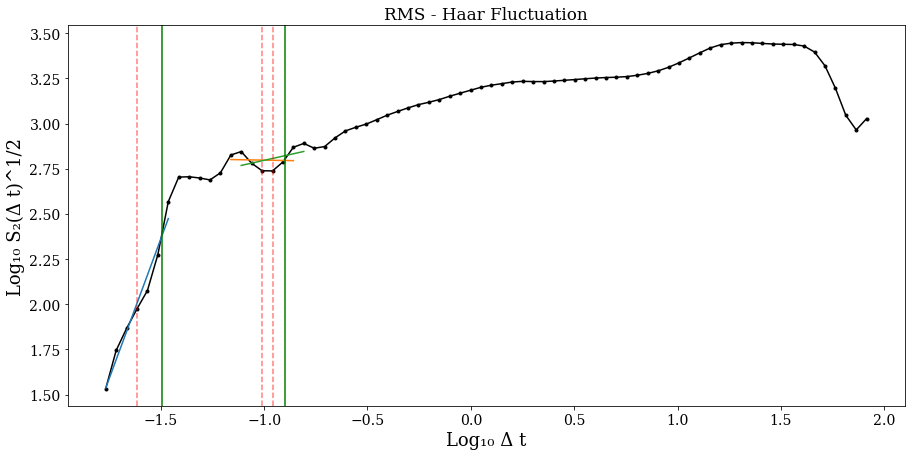

In [502]:
points=int(len(time)*0.1) #10% de los binnings

plt.subplots(figsize=(15, 7))
plt.plot(time,np.log10(amp),'.-',color='black')

slopes=np.array([])
interceptions=np.array([])
for i in range(len(time)-points-1): #Porque hasta -1? 
    slopes=np.append(slopes,linregress(time[i:i+points], np.log10(amp[i:i+points]))[0])
    interceptions=np.append(interceptions,linregress(time[i:i+points], np.log10(amp[i:i+points]))[1])
    #plt.plot(time[i:i+points],time[i:i+points]*slopes[i]+interceptions[i],'-')
    #print('slope ',i+1,': ',time[i:i+points],' ->',slopes[-1])

    
slope_dif=slopes[:-1]-slopes[1:]
possible_tc=np.array([])
for i in range(len(time[1:-points-1])):
    if slope_dif[i]<np.mean(slope_dif)-np.std(slope_dif) and time[i]<1:
        #plt.axvline(time[i+int(points/2)],color='r',label='cambio fuerte') 
        plt.plot(time[i:i+points],time[i:i+points]*slopes[i]+interceptions[i],'-')
        possible_tc=np.append(possible_tc,time[i+int(points/2)])
        plt.axvline(possible_tc[-1],color='r',linestyle='--',alpha=0.5) 
        
        print('Posible tau_c: ',10**possible_tc[-1]*1000,' y   dif n°',i)
print('\nPromedio tc: ',np.mean(possible_tc))
print('\nStd tc: ',np.std(possible_tc))
print('\nRango tc: [',10**(np.mean(possible_tc)-np.std(possible_tc))*1000,',',10**(np.mean(possible_tc)+np.std(possible_tc))*1000,']')

plt.axvline(np.mean(possible_tc)-np.std(possible_tc),color='g',linestyle='-') 
plt.axvline(np.mean(possible_tc)+np.std(possible_tc),color='g',linestyle='-')

plt.title('RMS - Haar Fluctuation')
plt.xlabel('Log\u2081\u2080 \u0394 t',fontsize=18);plt.ylabel('Log\u2081\u2080 S\u2082(\u0394 t)^1/2',fontsize=18)
#plt.legend()
plt.show()

In [149]:
slope_dif=slopes[:-1]-slopes[1:]
for i in range(len(time[1:-points-1])):
    if slope_dif[i]<np.mean(slope_dif)-np.std(slope_dif) and time[i]<1:
        #plt.axvline(time[i+1],color='r',label='cambio fuerte') 
        #plt.plot(time[i:i+3],time[i:i+3]*slopes[i]+interceptions[i],'-',label=np.round(slopes[i],2))
        print('Posible tau_c: ',10**time[i+1]*1000,' y   dif n°',i)
#plt.title('RMS - Haar Fluctuation')
#plt.xlabel('Log\u2081\u2080 \u0394 t',fontsize=18);plt.ylabel('Log\u2081\u2080 S\u2082(\u0394 t)^1/2',fontsize=18)
#plt.legend()
#plt.show()


len dif_slopes:  62
62
Posible tau_c:  94.82580867520291  y   dif n° 5
Posible tau_c:  106.42051413760356  y   dif n° 6
Posible tau_c:  119.43294750170125  y   dif n° 7
Posible tau_c:  212.62686646290194  y   dif n° 12


In [188]:
possible_tc

array([-0.46108548])

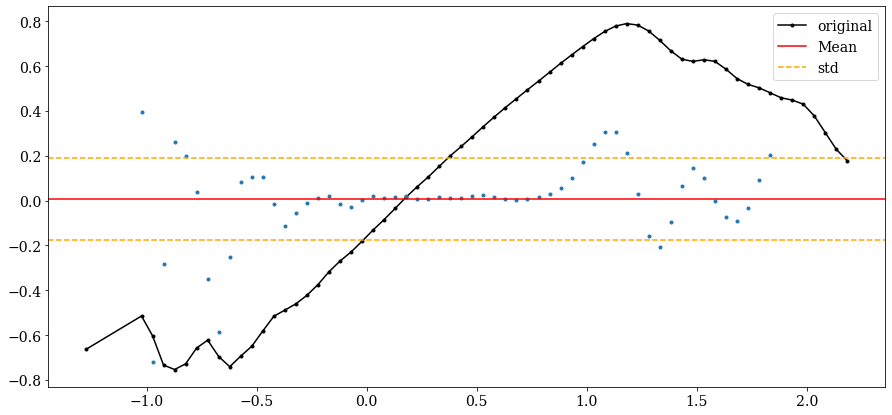

In [14]:
plt.subplots(figsize=(15, 7))
plt.plot(time,np.log10(amp),'.-',color='black',label='original')

plt.plot(time[1:-points-1],slope_dif,'.')
plt.axhline(y=np.mean(slope_dif),linestyle='-',color='r',label='Mean')
plt.axhline(y=np.mean(slope_dif)+np.std(slope_dif),linestyle='--',color='orange',label='std')
plt.axhline(y=np.mean(slope_dif)-np.std(slope_dif),linestyle='--',color='orange')
plt.plot()
#for i in range(len(time[1:-2])):
#    if abs(slopes[:-1]-slopes[1:])[i]>1.5:
#        plt.axvline(time[i+1],color='r',label='cambio fuerte')
plt.legend()
plt.show()

Posible tau_c:  54.72179764447675  y   dif n° 7
Posible tau_c:  61.457878048094756  y   dif n° 8
Posible tau_c:  69.02314866762642  y   dif n° 9
Posible tau_c:  77.51968019893182  y   dif n° 10
Posible tau_c:  87.06210791805236  y   dif n° 11
Posible tau_c:  97.7791783413348  y   dif n° 12

Promedio tc:  -1.1357966303689162

Std tc:  0.08610377048465893

Rango tc: [ 59.99286454219201 , 89.18814682160577 ]


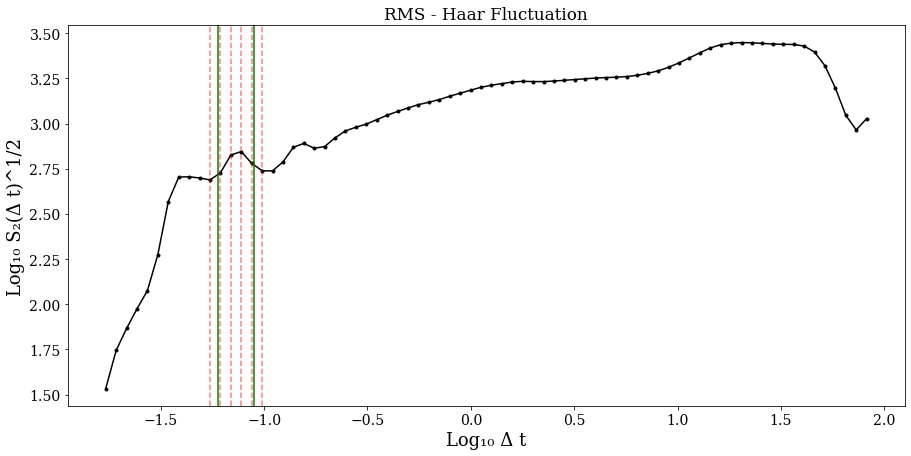

In [503]:
amp2=savgol_filter(np.log10(amp), window_length=window, polyorder=2, deriv=1,delta=1,mode='nearest')

points=int(len(time)*0.1) #10% de los binnings

plt.subplots(figsize=(15, 7))
plt.plot(time,np.log10(amp),'.-',color='black')

slopes=np.array([])
interceptions=np.array([])
for i in range(len(time)-points-1): #Porque hasta -1? 
    slopes=np.append(slopes,linregress(time[i:i+points], (amp2[i:i+points]))[0])
    interceptions=np.append(interceptions,linregress(time[i:i+points], (amp2[i:i+points]))[1])
    #plt.plot(time[i:i+points],time[i:i+points]*slopes[i]+interceptions[i],'-')
    #print('slope ',i+1,': ',time[i:i+points],' ->',slopes[-1])

    
slope_dif=slopes[:-1]-slopes[1:]
possible_tc=np.array([])
for i in range(len(time[1:-points-1])):
    if slope_dif[i]<np.mean(slope_dif)-np.std(slope_dif) and time[i]<1:
        #plt.axvline(time[i+int(points/2)],color='r',label='cambio fuerte') 
        #plt.plot(time[i:i+points],time[i:i+points]*slopes[i]+interceptions[i],'-')
        possible_tc=np.append(possible_tc,time[i+int(points/2)])
        plt.axvline(possible_tc[-1],color='r',linestyle='--',alpha=0.5) 
        
        print('Posible tau_c: ',10**possible_tc[-1]*1000,' y   dif n°',i)
print('\nPromedio tc: ',np.mean(possible_tc))
print('\nStd tc: ',np.std(possible_tc))
print('\nRango tc: [',10**(np.mean(possible_tc)-np.std(possible_tc))*1000,',',10**(np.mean(possible_tc)+np.std(possible_tc))*1000,']')

plt.axvline(np.mean(possible_tc)-np.std(possible_tc),color='g',linestyle='-') 
plt.axvline(np.mean(possible_tc)+np.std(possible_tc),color='g',linestyle='-')

plt.title('RMS - Haar Fluctuation')
plt.xlabel('Log\u2081\u2080 \u0394 t',fontsize=18);plt.ylabel('Log\u2081\u2080 S\u2082(\u0394 t)^1/2',fontsize=18)
#plt.legend()
plt.show()

Len T1:  134  Len T2:  534  Len T3:  200  Len T4:  600  Len T5:  500  Len T6:  500
Len total:  2468


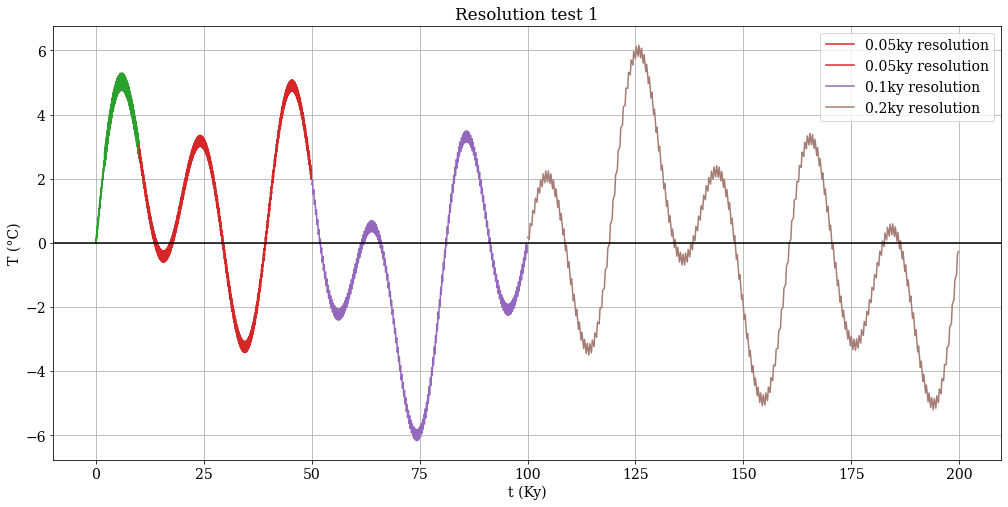

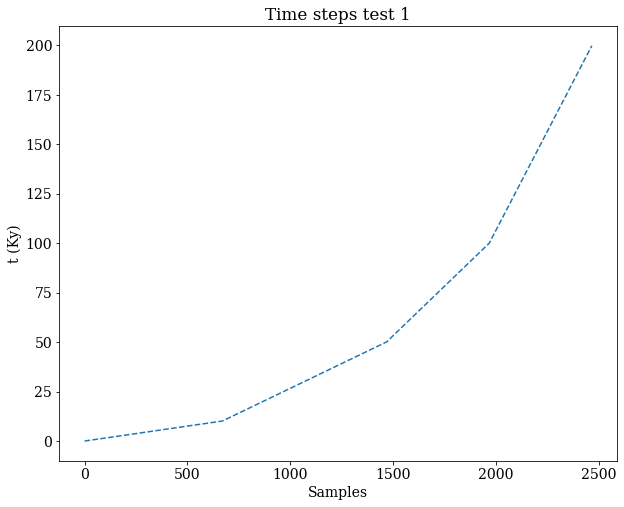

t samples: 2467
deltas_t steps: from 1 to 1234
epsilons steps: 1234
129675  fluctuaciones eliminadas ( 8.536551647865515 %)


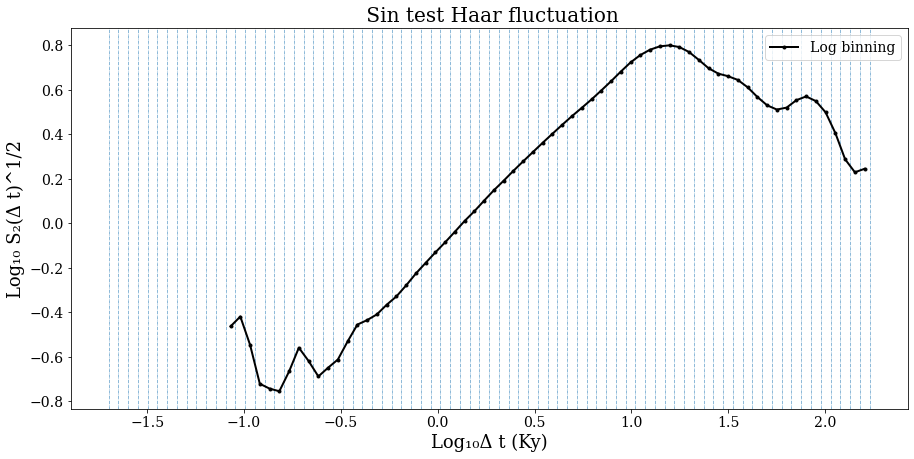

In [17]:
[t,T]=wave(0.015,0.015,0.05,0.05,0.1,0.2,'test 1')
ix=12
#t=lis[ix][lis[ix].columns[0]]
#T=lis[ix][lis[ix].columns[1]]
[delta_t,hs,time,amp,app,low]=Haar(t,T,plot=True,smooth=True)

[-1.01910169 -0.66657738 -0.61621676]


(-1.5, 2.4)

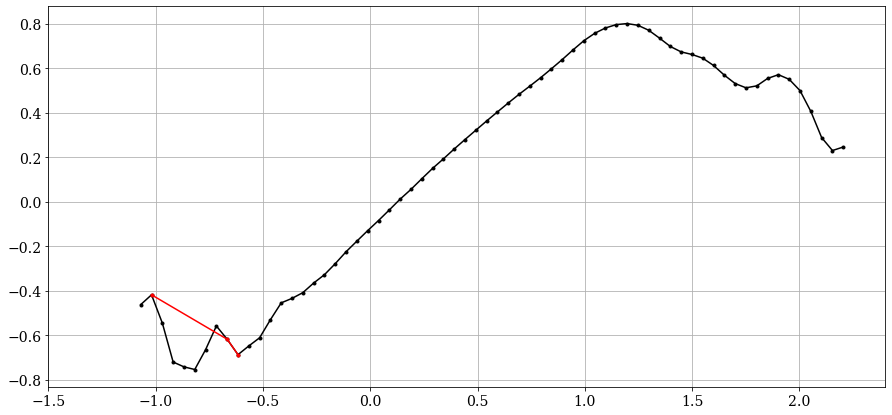

In [90]:
der2=savgol_filter(np.log10(amp), window_length=15, polyorder=9, deriv=1,delta=1,mode='nearest')

iq5=np.percentile(der2, 5,interpolation = 'midpoint')
iq20=np.percentile(der2, 20,interpolation = 'midpoint')

possible_tc=np.array([])
puntos=[]
for i in range(len(der2)):
    #if der2[i]<np.mean(der2)-np.std(der2) and time[i]<1:
    if der2[i]>iq5 and der2[i]<iq20 and time[i]<1:
        possible_tc=np.append(possible_tc,time[i])
        puntos.append(np.log10(amp)[i])
print(possible_tc)
plt.subplots(figsize=(15,7))
plt.plot(time,np.log10(amp),'.-',color='black')
plt.plot(possible_tc,puntos,'.-',color='r')

#plt.plot(p,s,label='ave')
plt.grid();plt.xlim([-1.5,2.4])

In [80]:
np.where(time==possible_tc[0])

(array([], dtype=int64),)

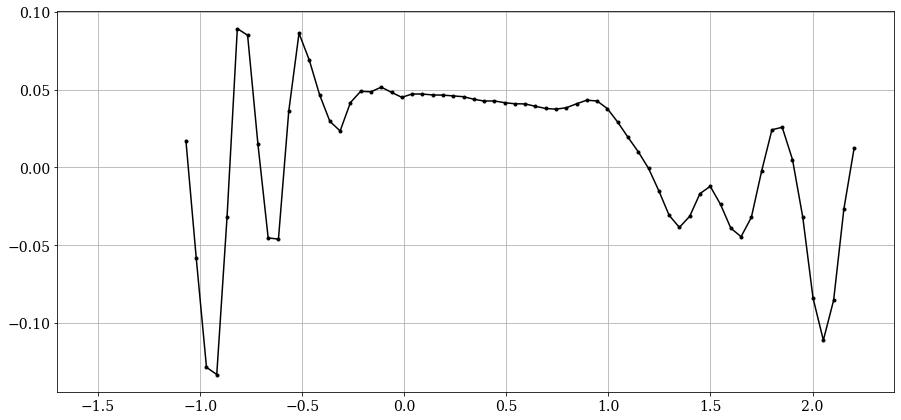

In [25]:
der2=savgol_filter(np.log10(amp), window_length=15, polyorder=9, deriv=1,delta=1,mode='nearest')
plt.subplots(figsize=(15, 7))
plt.plot(time,der2,'.-',color='black')
plt.xlim([-1.7,2.4]);plt.grid()
plt.show()

In [84]:
from scipy import stats 
z = np.abs(stats.zscore(der2))
print(z)
threshold = 3
 
# Position of the outlier
print(np.where(z > 2))

[0.13913814 1.39670058 2.8342754  2.92822216 0.86351077 1.60817802
 1.52029169 0.09848948 1.13692363 1.15263196 0.52137787 1.54718898
 1.19433217 0.74088617 0.3921513  0.26565867 0.63769701 0.78543415
 0.77932055 0.84000274 0.77145933 0.70669624 0.75018322 0.74969018
 0.73792214 0.73549452 0.7252309  0.71454952 0.68170857 0.65769059
 0.65926374 0.63610672 0.6221528  0.62006744 0.58871005 0.56052406
 0.55175257 0.57013911 0.6220474  0.66944913 0.65803833 0.55781115
 0.38146766 0.18260333 0.00730587 0.22580371 0.51928858 0.84059556
 0.99900949 0.85365113 0.55614111 0.46060547 0.69792757 1.00929439
 1.12082905 0.86689566 0.2592056  0.28125335 0.31382636 0.10945625
 0.86626462 1.92748957 2.47853515 1.95463218 0.75586025 0.04507035]
(array([ 2,  3, 62], dtype=int64),)


-0.02517799781397527